In [75]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import seaborn as sns
import pickle

sns.set(color_codes=True, style="white")

### Load Data

In [76]:
folder_FUS_FL = "/Volumes/lsa-nwalter/Guoming_Gao_turbo/Walterlab_server/PROCESSED_DATA/RNA-diffusion-in-FUS/RNAinFUS_PaperFigures/Fig4_regulation/FUS488_miR21_PAINT"
os.chdir(folder_FUS_FL)

switch_perLoc_perTrack = "perLoc"
# switch_perLoc_perTrack = "perTrack"

In [77]:
# Assume the following parameters are the same for all PairCorr-DataDict.p
if switch_perLoc_perTrack == "perLoc":
    dict_toplot = pickle.load(open("PairCorr-DataDict-pooled-perLoc.p", "rb"))
    dict_toplot_FL = pickle.load(open("PairCorr-DataDict-pooled-perLoc_FL.p", "rb"))
elif switch_perLoc_perTrack == "perTrack":
    dict_toplot = pickle.load(open("PairCorr-DataDict-pooled-perTrack.p", "rb"))
    dict_toplot_FL = pickle.load(open("PairCorr-DataDict-pooled-perTrack_FL.p", "rb"))

nm_per_pxl = dict_toplot["nm_per_pxl"]
r_max_nm = dict_toplot["r_max_nm"]
ringwidth_nm = dict_toplot["ringwidth_nm"]
dr_slidingrings_nm = dict_toplot["dr_slidingrings_nm"]
bins = dict_toplot["bins"]

### Functions

In [78]:
def weighted_stats(lst_PCF_per_condensate, lst_N_locations):
    # create arrays for weighted means, SEMs and STDs
    N_condensates = len(lst_N_locations)
    N_bins = lst_PCF_per_condensate[0].shape[0]
    weighted_mean = np.zeros(N_bins)
    weighted_sem = np.zeros(N_bins)
    weighted_std = np.zeros(N_bins)
    weights = np.array(lst_N_locations)

    # iterate over the length of a numpy array in the list
    for i in range(N_bins):
        # extract the i-th element from each array and their respective weight
        data_array = np.array(
            [lst_PCF_per_condensate[j][i] for j in range(N_condensates)]
        )
        # remove nan
        mask = np.isnan(data_array) | np.isnan(weights)
        data_array = data_array[~mask]
        # calculate the weighted mean
        weighted_mean[i] = np.average(data_array, weights=weights[~mask])
        # calculate the variance
        variance = np.average(
            (data_array - weighted_mean[i]) ** 2, weights=weights[~mask]
        )
        # calculate the weighted SEM
        weighted_sem[i] = np.sqrt(variance / N_condensates)
        # calculate the weighted STD
        weighted_std[i] = np.sqrt(variance)

    return weighted_mean, weighted_sem, weighted_std


def critical_system_PCF(r, A, r0):
    # r0 is the characteristic size of clustering
    Gr = 1 + A * np.exp(-r / r0)
    return Gr


def coscos_PCF(r, a1, b1, c1, a2, b2, c2, d):
    # a is amplitude
    # b is wave number, also called the angular frequency
    # c is phase shift
    # d is vertical shift or rest position
    Gr = a1 * np.cos(b1 * r + c1) + a2 * np.cos(b2 * r + c2) + d
    return Gr


def red_chi(bins, A, r0, weighted_mean, weighted_std):
    # Calculate chi square
    Gr_fitted = critical_system_PCF(bins, A, r0)
    residuals = weighted_mean - Gr_fitted
    variance = weighted_std**2
    chi_square = np.sum((residuals**2) / variance)
    # Calculate degrees of freedom
    dof = len(bins) - 2
    # Calculate reduced chi square
    reduced_chi_square = chi_square / dof
    return reduced_chi_square


def bootstrap(bins, lst_PCF_per_condensate, lst_N_locations, bs_size=30, bs_rounds=100):
    lst_A = []
    lst_r0 = []
    lst_red_chi2 = []
    for i in range(bs_rounds):
        idxs = np.random.choice(len(lst_PCF_per_condensate), bs_size)
        lst_PCF_bs = [lst_PCF_per_condensate[idx] for idx in idxs]

        idxs = np.random.choice(len(lst_N_locations), bs_size)
        lst_N_bs = [lst_N_locations[idx] for idx in idxs]

        weighted_mean, _, weighted_std = weighted_stats(lst_PCF_bs, lst_N_bs)

        popt, _ = curve_fit(critical_system_PCF, bins[1:], weighted_mean[1:])
        A, r0 = popt
        reduced_chi_square = red_chi(bins[1:], A, r0, weighted_mean[1:], weighted_std[1:])

        lst_A.append(A)
        lst_r0.append(r0)
        lst_red_chi2.append(reduced_chi_square)

    return lst_A, lst_r0, lst_red_chi2

### autoFUS individual

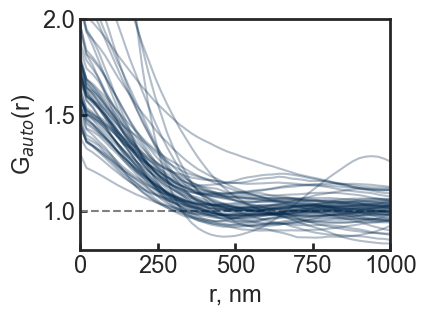

In [79]:
# Plot individual curves for perLoc
lst_PCF_per_condensate = dict_toplot["lst_auto_PCF_FUS"]

plt.figure(figsize=(4, 3))
plt.axhline(1, c="gray", ls="--")
for current_PCF in lst_PCF_per_condensate:
    plt.plot(bins, current_PCF, c="#00274c", alpha=0.3)
plt.xlim(bins[0], bins[-1])
plt.ylim(0.8, 2)
plt.xlabel("r, nm", fontsize=17)
plt.ylabel(r"G$_{auto}$(r)", fontsize=17)
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=17,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)
plt.savefig(
    "autoFUS_PCF_" + switch_perLoc_perTrack + "_individual.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

### autoFUS weighted mean, STD

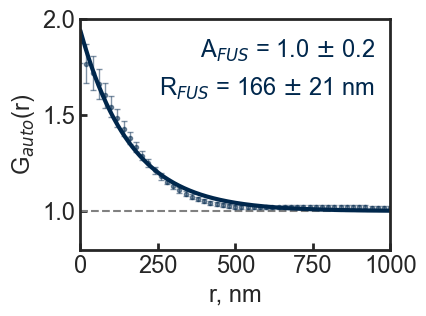

In [80]:
# Calculate the weighted mean, STD, SEM
lst_PCF_per_condensate = dict_toplot["lst_auto_PCF_FUS"]
lst_N_locations = dict_toplot["lst_N_locations_FUS"]

weighted_mean, weighted_sem, weighted_std = weighted_stats(
    lst_PCF_per_condensate, lst_N_locations
)

# calculate the characteristic cluster size by fitting
popt, pcov = curve_fit(critical_system_PCF, bins[1:], weighted_mean[1:])
A, r0 = popt
A_error, r0_error = np.sqrt(np.diag(pcov))
reduced_chi_square = red_chi(bins, A, r0, weighted_mean, weighted_std)

# Plot weighted mean curves + STD
plt.figure(figsize=(4, 3))
plt.axhline(1, c="gray", ls="--")
plt.errorbar(
    bins,
    weighted_mean,
    yerr=weighted_sem,
    fmt=".",
    color="#00274c",
    ecolor="#00274c",
    elinewidth=1,
    capsize=2,
    alpha=0.5,
)
r_fit = np.linspace(bins[0], bins[-1], 500)
gr_fit = critical_system_PCF(r_fit, A, r0)
plt.plot(r_fit, gr_fit, c="#00274c", lw=3)
plt.xlim(bins[0], bins[-1])
plt.ylim(0.8, 2)
plt.xlabel("r, nm", fontsize=17)
plt.ylabel(r"G$_{auto}$(r)", fontsize=17)
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=17,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)

# Bootstrapping
lst_A, lst_r0, lst_red_chi2 = bootstrap(
    bins,
    lst_PCF_per_condensate,
    lst_N_locations,
    40,
    3000,
)
ci_A = (np.percentile(lst_A, 5), np.percentile(lst_A, 95))
bs_A_mean = np.mean(ci_A)
bs_A_err = (ci_A[1] - ci_A[0]) / 2
ci_r0 = (np.percentile(lst_r0, 5), np.percentile(lst_r0, 95))
bs_r0_mean = np.mean(ci_r0)
bs_r0_err = (ci_r0[1] - ci_r0[0]) / 2

plt.text(
    950,
    1.8,
    r"A$_{FUS}$ = " + str(round(bs_A_mean, 1)) + r" $\pm$ " + str(round(bs_A_err, 1)),
    fontsize=17,
    color="#00274c",
    horizontalalignment='right',
)
plt.text(
    950,
    1.6,
    r"R$_{FUS}$ = "
    + str(round(bs_r0_mean))
    + r" $\pm$ "
    + str(round(bs_r0_err))
    + " nm",
    fontsize=17,
    color="#00274c",
    horizontalalignment='right',
)
plt.savefig(
    "autoFUS_PCF_" + switch_perLoc_perTrack + "_weighted_mean_SEM.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

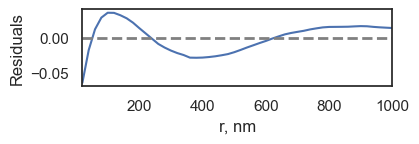

In [81]:
plt.figure(figsize=(4, 1))
plt.plot(bins[1:], weighted_mean[1:] - critical_system_PCF(bins[1:], A, r0))
plt.axhline(0, c="gray", ls="--", lw=2)
plt.xlim(bins[1], bins[-1])
plt.xlabel("r, nm")
plt.ylabel("Residuals")
plt.savefig(
    "autoFUS_PCF_" + switch_perLoc_perTrack + "_weighted_mean_SEM-residuals.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

### auto RNA individual

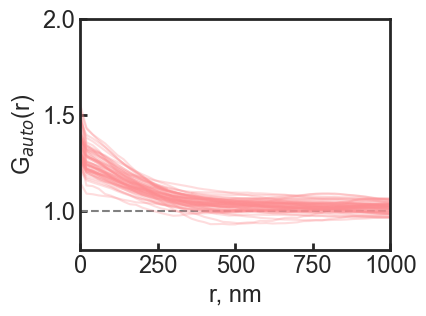

In [82]:
# Plot individual curves for perLoc
lst_PCF_per_condensate = dict_toplot["lst_auto_PCF_RNA"]

plt.figure(figsize=(4, 3))
plt.axhline(1, c="gray", ls="--")
for current_PCF in lst_PCF_per_condensate:
    plt.plot(bins, current_PCF, c="#fc8d91", alpha=0.3)
plt.xlim(bins[0], bins[-1])
plt.ylim(0.8, 2)
plt.xlabel("r, nm", fontsize=17)
plt.ylabel(r"G$_{auto}$(r)", fontsize=17)
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=17,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)
plt.savefig(
    "autoRNA_PCF_" + switch_perLoc_perTrack + "_individual.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

### auto RNA weighted mean + STD

In [83]:
lst_PCF_per_condensate = dict_toplot_FL["lst_auto_PCF_RNA"]
lst_N_locations = dict_toplot_FL["lst_N_locations_RNA"]

weighted_mean_FL, weighted_sem_FL, weighted_std_FL = weighted_stats(
    lst_PCF_per_condensate, lst_N_locations
)
popt, pcov = curve_fit(critical_system_PCF, bins[1:], weighted_mean_FL[1:])
a_FL, r0_FL = popt

# Bootstrapping
lst_A_FL, lst_r0_FL, lst_red_chi2_FL = bootstrap(
    bins,
    lst_PCF_per_condensate,
    lst_N_locations,
    30,
    5000,
)
ci_A = (np.percentile(lst_A_FL, 5), np.percentile(lst_A_FL, 95))
bs_A_mean_FL = np.mean(ci_A)
bs_A_err_FL = (ci_A[1] - ci_A[0]) / 2
ci_r0 = (np.percentile(lst_r0_FL, 5), np.percentile(lst_r0_FL, 95))
bs_r0_mean_FL = np.mean(ci_r0)
bs_r0_err_FL = (ci_r0[1] - ci_r0[0]) / 2

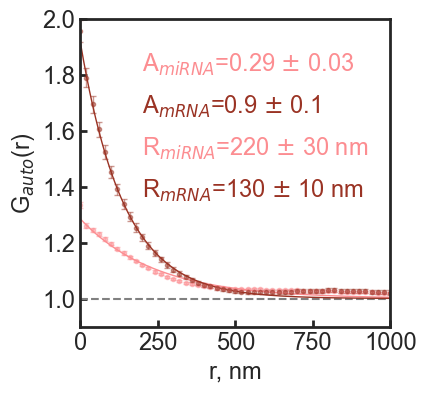

In [84]:
# Calculate the weighted mean, STD, SEM
lst_PCF_per_condensate = dict_toplot["lst_auto_PCF_RNA"]
lst_N_locations = dict_toplot["lst_N_locations_RNA"]

weighted_mean, weighted_sem, weighted_std = weighted_stats(
    lst_PCF_per_condensate, lst_N_locations
)

# calculate the characteristic cluster size by fitting
popt, pcov = curve_fit(critical_system_PCF, bins[1:], weighted_mean[1:])
A, r0 = popt
A_error, r0_error = np.sqrt(np.diag(pcov))
reduced_chi_square = red_chi(bins, A, r0, weighted_mean, weighted_std)

# Plot weighted mean curves + STD
plt.figure(figsize=(4, 4))
plt.axhline(1, c="gray", ls="--")
plt.errorbar(
    bins,
    weighted_mean,
    yerr=weighted_sem,
    fmt=".",
    color="#fc8d91",
    ecolor="#fc8d91",
    elinewidth=1,
    capsize=2,
    alpha=0.5,
)
plt.errorbar(
    bins,
    weighted_mean_FL,
    yerr=weighted_sem_FL,
    fmt=".",
    color="#9a3324",
    ecolor="#9a3324",
    elinewidth=1,
    capsize=2,
    alpha=0.5,
)
r_fit = np.linspace(bins[0], bins[-1], 500)
gr_fit = critical_system_PCF(r_fit, A, r0)
plt.plot(r_fit, gr_fit, c="#fc8d91", lw=1)
plt.plot(r_fit, critical_system_PCF(r_fit, a_FL, r0_FL), c="#9a3324", lw=1)
plt.xlim(bins[0], bins[-1])
plt.ylim(0.9, 2)
plt.xlabel("r, nm", fontsize=17)
plt.ylabel(r"G$_{auto}$(r)", fontsize=17)
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=17,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)

# Bootstrapping
lst_A, lst_r0, lst_red_chi2 = bootstrap(
    bins,
    lst_PCF_per_condensate,
    lst_N_locations,
    30,
    3000,
)
ci_A = (np.percentile(lst_A, 5), np.percentile(lst_A, 95))
bs_A_mean = np.mean(ci_A)
bs_A_err = (ci_A[1] - ci_A[0]) / 2
ci_r0 = (np.percentile(lst_r0, 5), np.percentile(lst_r0, 95))
bs_r0_mean = np.mean(ci_r0)
bs_r0_err = (ci_r0[1] - ci_r0[0]) / 2

left = 200
top = 1.81
gap = 0.15
plt.text(
    left,
    top,
    r"A$_{miRNA}$="
    + "{:.2f}".format(round(bs_A_mean, 2))
    + r" $\pm$ "
    + "{:.2f}".format(round(bs_A_err, 2)),
    fontsize=17,
    color="#fc8d91",
    horizontalalignment="left",
)
plt.text(
    left,
    top - gap * 1,
    r"A$_{mRNA}$="
    + "{:.1f}".format(round(bs_A_mean_FL, 2))
    + r" $\pm$ "
    + "{:.1f}".format(round(bs_A_err_FL, 2)),
    fontsize=17,
    color="#9a3324",
    horizontalalignment="left",
)
plt.text(
    left,
    top - gap * 2,
    r"R$_{miRNA}$="
    + '{:.0f}'.format(round(bs_r0_mean) // 10 * 10) # round to tenth digit
    + r" $\pm$ "
    + '{:.0f}'.format(round(bs_r0_err) // 10 * 10)
    + " nm",
    fontsize=17,
    color="#fc8d91",
    horizontalalignment="left",
)
plt.text(
    left,
    top - gap * 3,
    r"R$_{mRNA}$="
    + '{:.0f}'.format(round(bs_r0_mean_FL) // 10 * 10) # round to tenth digit
    + r" $\pm$ "
    + '{:.0f}'.format(round(bs_r0_err_FL) // 10 * 10)
    + " nm",
    fontsize=17,
    color="#9a3324",
    horizontalalignment="left",
)

plt.savefig(
    "autoRNA_PCF_" + switch_perLoc_perTrack + "_weighted_mean_SEM.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

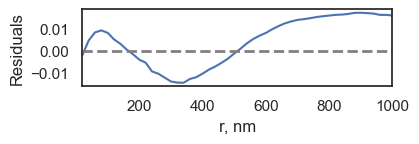

In [85]:
plt.figure(figsize=(4, 1))
plt.plot(bins[1:], weighted_mean[1:] - critical_system_PCF(bins[1:], A, r0))
plt.axhline(0, c="gray", ls="--", lw=2)
plt.xlim(bins[1], bins[-1])
plt.xlabel("r, nm")
plt.ylabel("Residuals")
plt.savefig(
    "autoRNA_PCF_" + switch_perLoc_perTrack + "_weighted_mean_SEM-residuals.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

### cross individual

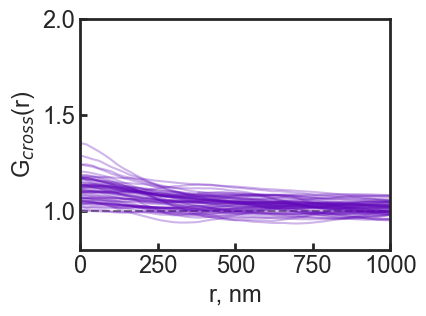

In [86]:
# Plot individual curves for perLoc
lst_PCF_per_condensate = dict_toplot['lst_cross_PCF_FUSref']
plt.figure(figsize=(4, 3))
plt.axhline(1, c="gray", ls="--")
for current_PCF in lst_PCF_per_condensate:
    plt.plot(bins, current_PCF, c="#6209ba", alpha=0.3)
plt.xlim(bins[0], bins[-1])
plt.ylim(0.8, 2)
plt.xlabel("r, nm", fontsize=17)
plt.ylabel(r"G$_{cross}$(r)", fontsize=17)
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=17,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)
plt.savefig(
    "cross_PCF_FUSref_" + switch_perLoc_perTrack + "_individual.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

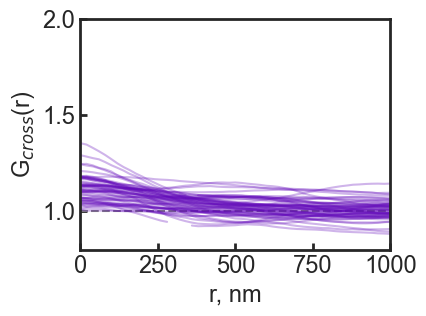

In [87]:
# Plot individual curves for perLoc
lst_PCF_per_condensate = dict_toplot['lst_cross_PCF_RNAref']
plt.figure(figsize=(4, 3))
plt.axhline(1, c="gray", ls="--")
for current_PCF in lst_PCF_per_condensate:
    plt.plot(bins, current_PCF, c="#6209ba", alpha=0.3)
plt.xlim(bins[0], bins[-1])
plt.ylim(0.8, 2)
plt.xlabel("r, nm", fontsize=17)
plt.ylabel(r"G$_{cross}$(r)", fontsize=17)
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=17,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)
plt.savefig(
    "cross_PCF_RNAref_" + switch_perLoc_perTrack + "_individual.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

### cross weighted mean + STD

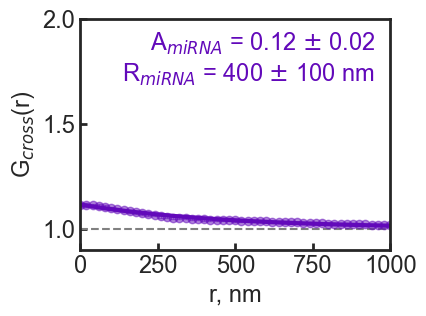

In [88]:
# Calculate the weighted mean, STD, SEM
lst_PCF_per_condensate = dict_toplot["lst_cross_PCF_FUSref"]
lst_N_locations_FUS = dict_toplot["lst_N_locations_FUS"]
lst_N_locations_RNA = dict_toplot["lst_N_locations_RNA"]
lst_N_locations = [a + b for a, b in zip(lst_N_locations_FUS, lst_N_locations_RNA)]

weighted_mean, weighted_sem, weighted_std = weighted_stats(
    lst_PCF_per_condensate, lst_N_locations
)

# calculate the characteristic cluster size by fitting
popt, pcov = curve_fit(critical_system_PCF, bins[1:], weighted_mean[1:])
A, r0 = popt
A_error, r0_error = np.sqrt(np.diag(pcov))
reduced_chi_square = red_chi(bins, A, r0, weighted_mean, weighted_std)

# Plot weighted mean curves + SEM
plt.figure(figsize=(4, 3))
plt.axhline(1, c="gray", ls="--")
plt.errorbar(
    bins,
    weighted_mean,
    yerr=weighted_sem,
    fmt="o",
    color="#6209ba",
    ecolor="#6209ba",
    elinewidth=1,
    capsize=2,
    alpha=0.5,
)
r_fit = np.linspace(bins[0], bins[-1], 500)
gr_fit = critical_system_PCF(r_fit, A, r0)
plt.plot(r_fit, gr_fit, c="#6209ba", lw=3)
plt.xlim(bins[0], bins[-1])
plt.ylim(0.9, 2)
plt.xlabel("r, nm", fontsize=17)
plt.ylabel(r"G$_{cross}$(r)", fontsize=17)
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=17,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)

# Bootstrapping
lst_A, lst_r0, lst_red_chi2 = bootstrap(
    bins,
    lst_PCF_per_condensate,
    lst_N_locations,
    40,
    5000,
)
ci_A = (np.percentile(lst_A, 5), np.percentile(lst_A, 95))
bs_A_mean = np.mean(ci_A)
bs_A_err = (ci_A[1] - ci_A[0]) / 2
ci_r0 = (np.percentile(lst_r0, 5), np.percentile(lst_r0, 95))
bs_r0_mean = np.mean(ci_r0)
bs_r0_err = (ci_r0[1] - ci_r0[0]) / 2

plt.text(
    950,
    1.85,
    r"A$_{miRNA}$ = " + str(round(bs_A_mean, 2)) + r" $\pm$ " + str(round(bs_A_err, 2)),
    fontsize=17,
    color="#6209ba",
    horizontalalignment='right',
)
plt.text(
    950,
    1.7,
    r"R$_{miRNA}$ = "
    + '{:.0f}'.format(round(bs_r0_mean, -2))
    + r" $\pm$ "
    + '{:.0f}'.format(round(bs_r0_err, -2))
    + " nm",
    fontsize=17,
    color="#6209ba",
    horizontalalignment='right',
)
plt.savefig(
    "cross_PCF_FUSref_" + switch_perLoc_perTrack + "_weighted_mean_SEM.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

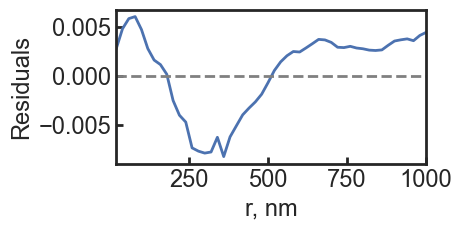

In [89]:
plt.figure(figsize=(4, 2))
plt.plot(bins[1:], weighted_mean[1:] - critical_system_PCF(bins[1:], A, r0), lw=2)
plt.axhline(0, c="gray", ls="--", lw=2)
plt.xlabel("r, nm", fontsize=17)
plt.xlim(bins[1], bins[-1])
plt.ylabel("Residuals", fontsize=17)
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=17,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)
plt.savefig(
    "cross_PCF_FUSref_" + switch_perLoc_perTrack + "_weighted_mean_SEM-residuals.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

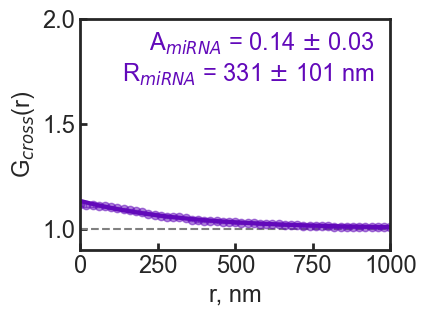

In [90]:
# Calculate the weighted mean, STD, SEM
lst_PCF_per_condensate = dict_toplot["lst_cross_PCF_RNAref"]
lst_N_locations_FUS = dict_toplot["lst_N_locations_FUS"]
lst_N_locations_RNA = dict_toplot["lst_N_locations_RNA"]
lst_N_locations = [a + b for a, b in zip(lst_N_locations_FUS, lst_N_locations_RNA)]

weighted_mean, weighted_sem, weighted_std = weighted_stats(
    lst_PCF_per_condensate, lst_N_locations
)

# calculate the characteristic cluster size by fitting
popt, pcov = curve_fit(critical_system_PCF, bins[1:], weighted_mean[1:])
A, r0 = popt
A_error, r0_error = np.sqrt(np.diag(pcov))
reduced_chi_square = red_chi(bins, A, r0, weighted_mean, weighted_std)

# Plot weighted mean curves + STD
plt.figure(figsize=(4, 3))
plt.axhline(1, c="gray", ls="--")
plt.errorbar(
    bins,
    weighted_mean,
    yerr=weighted_sem,
    fmt="o",
    color="#6209ba",
    ecolor="#6209ba",
    elinewidth=1,
    capsize=2,
    alpha=0.5,
)
r_fit = np.linspace(bins[0], bins[-1], 500)
gr_fit = critical_system_PCF(r_fit, A, r0)
plt.plot(r_fit, gr_fit, c="#6209ba", lw=3)
plt.xlim(bins[0], bins[-1])
plt.ylim(0.9, 2)
plt.xlabel("r, nm", fontsize=17)
plt.ylabel(r"G$_{cross}$(r)", fontsize=17)
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=17,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)

# Bootstrapping
lst_A, lst_r0, lst_red_chi2 = bootstrap(
    bins,
    lst_PCF_per_condensate,
    lst_N_locations,
    40,
    5000,
)
ci_A = (np.percentile(lst_A, 5), np.percentile(lst_A, 95))
bs_A_mean = np.mean(ci_A)
bs_A_err = (ci_A[1] - ci_A[0]) / 2
ci_r0 = (np.percentile(lst_r0, 5), np.percentile(lst_r0, 95))
bs_r0_mean = np.mean(ci_r0)
bs_r0_err = (ci_r0[1] - ci_r0[0]) / 2

plt.text(
    950,
    1.85,
    r"A$_{miRNA}$ = " + str(round(bs_A_mean, 2)) + r" $\pm$ " + str(round(bs_A_err, 2)),
    fontsize=17,
    color="#6209ba",
    horizontalalignment='right',
)
plt.text(
    950,
    1.7,
    r"R$_{miRNA}$ = "
    + str(round(bs_r0_mean))
    + r" $\pm$ "
    + str(round(bs_r0_err))
    + " nm",
    fontsize=17,
    color="#6209ba",
    horizontalalignment='right',
)
plt.savefig(
    "cross_PCF_RNAref_" + switch_perLoc_perTrack + "_weighted_mean_SEM.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

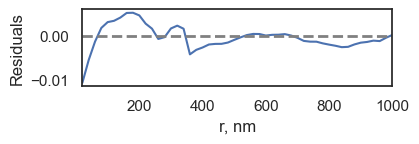

In [91]:
plt.figure(figsize=(4, 1))
plt.plot(bins[1:], weighted_mean[1:] - critical_system_PCF(bins[1:], A, r0))
plt.axhline(0, c="gray", ls="--", lw=2)
plt.xlabel("r, nm")
plt.xlim(bins[1], bins[-1])
plt.ylabel("Residuals")
plt.savefig(
    "cross_PCF_RNAref_" + switch_perLoc_perTrack + "_weighted_mean_SEM-residuals.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

### Bootstrap histogram comparison

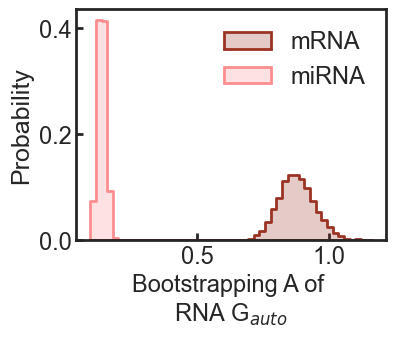

In [92]:
df_hist = pd.DataFrame(
    {
        "value": lst_A_FL + lst_A,
        "label": np.concatenate(
            [
                np.repeat("mRNA", len(lst_A_FL)),
                np.repeat("miRNA", len(lst_A)),
            ]
        ),
    },
    dtype=object,
)
plt.figure(figsize=(4, 3))
ax = sns.histplot(
    data=df_hist,
    x="value",
    hue="label",
    hue_order=['mRNA', 'miRNA'],
    palette=['#9a3324', '#fc8d91'],
    bins=50,
    stat="probability",
    common_norm=False,
    lw=2,
    element='step',
)
sns.move_legend(ax, 0, title=None, frameon=False, fontsize=17)
plt.xlabel("Bootstrapping A of \nRNA G$_{auto}$", fontsize=17)
plt.ylabel("Probability", fontsize=18)
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=17,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)
plt.savefig(
    "autoRNA_PCF_" + switch_perLoc_perTrack + "_bootstrap_histo_compare_A.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

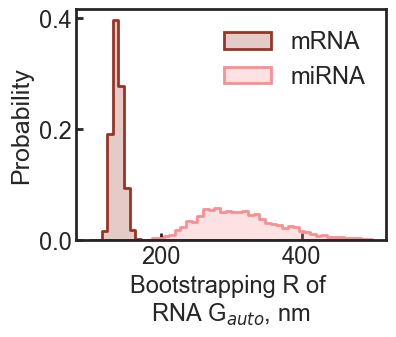

In [98]:
df_hist = pd.DataFrame(
    {
        "value": lst_r0_FL + lst_r0,
        "label": np.concatenate(
            [
                np.repeat("mRNA", len(lst_r0_FL)),
                np.repeat("miRNA", len(lst_r0)),
            ]
        ),
    },
    dtype=object,
)
plt.figure(figsize=(4, 3))
ax = sns.histplot(
    data=df_hist,
    x="value",
    hue="label",
    hue_order=["mRNA", "miRNA"],
    palette=["#9a3324", "#fc8d91"],
    bins=50,
    binrange=(100, 500),
    stat="probability",
    common_norm=False,
    lw=2,
    element="step",
)
sns.move_legend(ax, 0, title=None, frameon=False, fontsize=17)
plt.xlabel("Bootstrapping R of \nRNA G$_{auto}$, nm", fontsize=17)
plt.ylabel("Probability", fontsize=18)
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=17,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)
plt.savefig(
    "autoRNA_PCF_" + switch_perLoc_perTrack + "_bootstrap_histo_compare_R.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

In [94]:
lst_PCF_per_condensate = dict_toplot_FL["lst_auto_PCF_FUS"]
lst_N_locations = dict_toplot_FL["lst_N_locations_FUS"]
# Bootstrapping
lst_A_autoFUSinFL, lst_r0_autoFUSinFL, _ = bootstrap(
    bins,
    lst_PCF_per_condensate,
    lst_N_locations,
    30,
    3000,
)

lst_PCF_per_condensate = dict_toplot["lst_auto_PCF_FUS"]
lst_N_locations = dict_toplot["lst_N_locations_FUS"]
# Bootstrapping
lst_A_autoFUSinmiR, lst_r0_autoFUSinmiR, _ = bootstrap(
    bins,
    lst_PCF_per_condensate,
    lst_N_locations,
    30,
    3000,
)

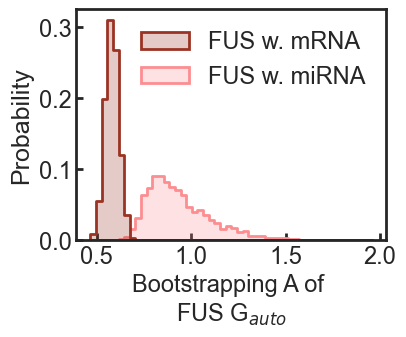

In [95]:
df_hist = pd.DataFrame(
    {
        "value": lst_A_autoFUSinFL + lst_A_autoFUSinmiR,
        "label": np.concatenate(
            [
                np.repeat("FUS w. mRNA", len(lst_A_autoFUSinFL)),
                np.repeat("FUS w. miRNA", len(lst_A_autoFUSinmiR)),
            ]
        ),
    },
    dtype=object,
)
plt.figure(figsize=(4, 3))
ax = sns.histplot(
    data=df_hist,
    x="value",
    hue="label",
    hue_order=["FUS w. mRNA", "FUS w. miRNA"],
    palette=["#9a3324", "#fc8d91"],
    bins=50,
    stat="probability",
    common_norm=False,
    lw=2,
    element="step",
)
sns.move_legend(ax, 0, title=None, frameon=False, fontsize=17)
plt.xlabel("Bootstrapping A of \nFUS G$_{auto}$", fontsize=17)
plt.ylabel("Probability", fontsize=18)
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=17,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)
plt.savefig(
    "autoFUS_PCF_" + switch_perLoc_perTrack + "_bootstrap_histo_compare_A.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

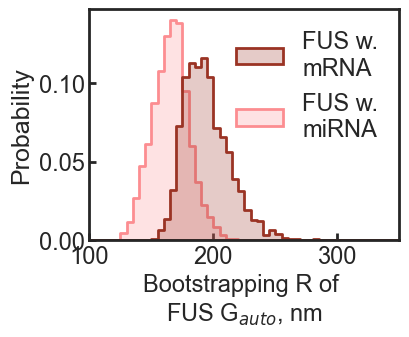

In [96]:
df_hist = pd.DataFrame(
    {
        "value": lst_r0_autoFUSinFL + lst_r0_autoFUSinmiR,
        "label": np.concatenate(
            [
                np.repeat("FUS w.\nmRNA", len(lst_r0_autoFUSinFL)),
                np.repeat("FUS w.\nmiRNA", len(lst_r0_autoFUSinmiR)),
            ]
        ),
    },
    dtype=object,
)
plt.figure(figsize=(4, 3))
ax = sns.histplot(
    data=df_hist,
    x="value",
    hue="label",
    hue_order=["FUS w.\nmRNA", "FUS w.\nmiRNA"],
    palette=["#9a3324", "#fc8d91"],
    bins=50,
    binrange=(100, 350),
    stat="probability",
    common_norm=False,
    lw=2,
    element="step",
)
plt.xlim(100, 350)
sns.move_legend(ax, 0, title=None, frameon=False, fontsize=17)
plt.xlabel("Bootstrapping R of \nFUS G$_{auto}$, nm", fontsize=17)
plt.ylabel("Probability", fontsize=18)
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=17,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)
plt.savefig(
    "autoFUS_PCF_" + switch_perLoc_perTrack + "_bootstrap_histo_compare_R.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)